## m1 Popularity, PCA reduction
The analysis follows the following steps:
1. Exploration of PCA reduction, with simple regression (subsets)
2. Given a reduction, experiment with ridge, elastic net, polynomial regression, k-neighbors, suport vector regression
3. Hyperparameter exploration

### Setup

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from scipy import stats 

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

sns.set_theme()
# Show plots
viz = True

In [2]:
# Load FOLD f1
df_train = pd.read_csv('data/fold/f1_train.csv',  parse_dates=['release'])
df_train = df_train.drop(columns=['release'])
df_test = pd.read_csv('data/fold/f1_test.csv',  parse_dates=['release'])
df_test = df_test.drop(columns=['release'])

In [3]:
class Feats():
    """
    Each feature has a first name, optionally a second name, a statistic and a number.
    This class allows to group feautures according to these aspects or combinations of these aspects.
    Each method produces a list of feature names or a list of lists of feature names.
    """

    def __init__(self, csv):
        self.fts = pd.read_csv(csv, dtype={'n':"string"})
        self.fts = self.fts.fillna('')

    def format(self, select):
        return select.apply(lambda x: '_'.join(x).replace('__', '_'), axis=1).tolist()

    def all(self):
        select = self.fts.copy()
        return self.format(select)

    def first(self):
        select = self.fts.copy()
        select = select.loc[select['n']=='01']
        return self.format(select)

    def mfcc(self):
        select = self.fts.copy()
        select = select.loc[select['name1']=='mfcc']
        return self.format(select)

    def tonnetz(self):
        select = self.fts.copy()
        select = select.loc[select['name1']=='tonnetz']
        return self.format(select)

    def min(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='min']
        return self.format(select)
    
    def max(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='max']
        return self.format(select)

    def median(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='median']
        return self.format(select)

    def mean(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='mean']
        return self.format(select)
    
    def std(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='std']
        return self.format(select)

    def skew(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='skew']
        return self.format(select)

    def kurtosis(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='kurtosis']
        return self.format(select)

    def per_nns(self):
        """
        List of lists per name1, name2, stat, per name1, name2.
        """
        select = self.fts.copy()
        select = [[self.format(grp2) for idx2, grp2 in grp.groupby(by=['stat'], sort=False)] for idx, grp in select.groupby(by=['name1', 'name2'])]
        return select
    
    def per_sn(self):
        """
        List of lists per stat, n. 
        """
        select = self.fts.copy()
        select = [[self.format(grp2) for idx2, grp2 in grp.groupby(by=['n'], sort=False)] for idx, grp in select.groupby(by=['stat'], sort=False)]
        return select

fts = Feats('features.csv')

#### Preprocessing

Train set: Dropped 0 na entries and 1 zero entries of 68207, 68206 entries left.
Test set: Dropped 0 na entries and 0 zero entries of 17052, 17052 entries left.


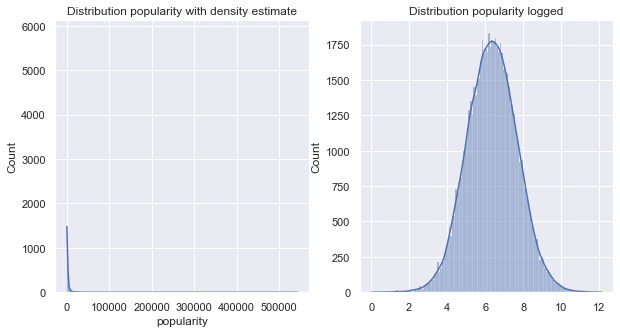

In [4]:
# Drop na values train
n_orig = df_train.shape[0]
n_na = df_train['popularity'].isna().sum()
df_train = df_train.dropna(subset=['popularity'])

# Drop zero values train
n_zero =df_train.loc[df_train['popularity']==0].shape[0]
df_train = df_train.loc[df_train['popularity']>0]

print(f'Train set: Dropped {n_na} na entries and {n_zero} zero entries of {n_orig}, {df_train.shape[0]} entries left.')

# Drop na values test
n_orig = df_test.shape[0]
n_na = df_test['popularity'].isna().sum()
df_test = df_test.dropna(subset=['popularity'])

# Drop zero values test
n_zero =df_test.loc[df_test['popularity']==0].shape[0]
df_test = df_test.loc[df_test['popularity']>0]

print(f'Test set: Dropped {n_na} na entries and {n_zero} zero entries of {n_orig}, {df_test.shape[0]} entries left.')

# Transform y train
y_train_before = df_train['popularity']
y_train = stats.boxcox(y_train_before)[0]

# Transform y test
y_test_before = df_test['popularity']
y_test = stats.boxcox(y_test_before)[0]

if viz:
    fig, axs = plt.subplots(ncols=2, figsize=(10,5))

    ax1 = sns.histplot(x=y_train_before, kde=True, ax=axs[0])
    ax1.set(title="Distribution popularity with density estimate")
    
    ax2 = sns.histplot(x=y_train, kde=True, ax=axs[1])
    ax2.set(title="Distribution popularity logged")
    
    fig;

# Scale X
X_train = df_train.drop(columns=['popularity'])
X_test = df_test.drop(columns=['popularity'])

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=fts.all())
X_test = pd.DataFrame(X_test, columns=fts.all())

# print(f'Mean x: {X_train.mean().tolist()[:6]}..., Std: {X_train.std().tolist()[:6]}...')

### 1. PCA reduction

- In feats selection: all > mean > first
- In n components: 2 ~ 10 ~ 50 ~ 250

If there is no difference between 2 and 250, might as well work with 2, computationally more interesting.

#### Feats

Linear regression: r2: 0.1374642090606082


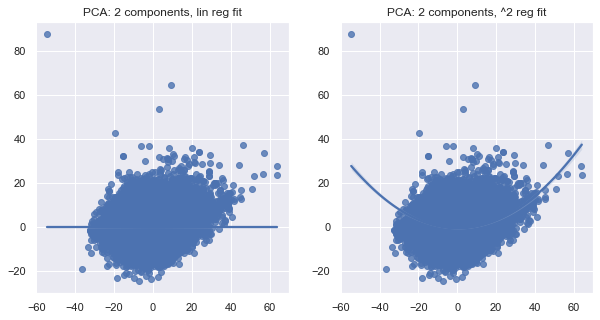

In [6]:
X_train_fts = X_train[fts.all()]

pca = PCA(n_components=2)
pca.fit(X_train_fts)

components = pca.transform(X_train_fts)
components_t = components.T

if viz:
    fig, axs = plt.subplots(ncols=2, figsize=(10,5))

    ax1 = sns.regplot(x=components_t[0], y=components_t[1], order=1, ax=axs[0]);
    ax1.set(title="PCA: 2 components, lin reg fit")
    
    ax2 = sns.regplot(x=components_t[0], y=components_t[1], order=2, ax=axs[1]);
    ax2.set(title="PCA: 2 components, ^2 reg fit")
    
    fig;


model = LinearRegression().fit(X_train_fts, y_train)

score = model.score(X_train_fts, y_train)
print(f'Linear regression: r2: {score}')

Linear regression: r2: 0.08183022449463462


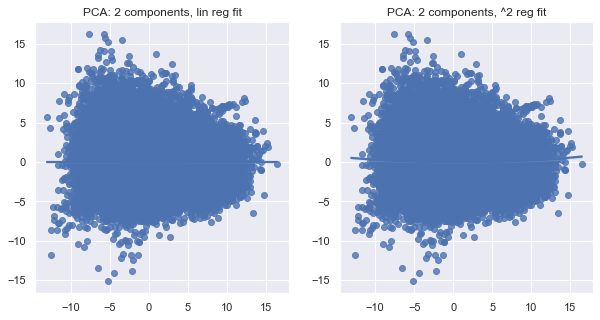

In [7]:
X_train_fts = X_train[fts.mean()]

pca = PCA(n_components=2)
pca.fit(X_train_fts)

components = pca.transform(X_train_fts)
components_t = components.T

if viz:
    fig, axs = plt.subplots(ncols=2, figsize=(10,5))

    ax1 = sns.regplot(x=components_t[0], y=components_t[1], order=1, ax=axs[0]);
    ax1.set(title="PCA: 2 components, lin reg fit")
    
    ax2 = sns.regplot(x=components_t[0], y=components_t[1], order=2, ax=axs[1]);
    ax2.set(title="PCA: 2 components, ^2 reg fit")
    
    fig;


model = LinearRegression().fit(X_train_fts, y_train)

score = model.score(X_train_fts, y_train)
print(f'Linear regression: r2: {score}')

Linear regression: r2: 0.06905941070561639


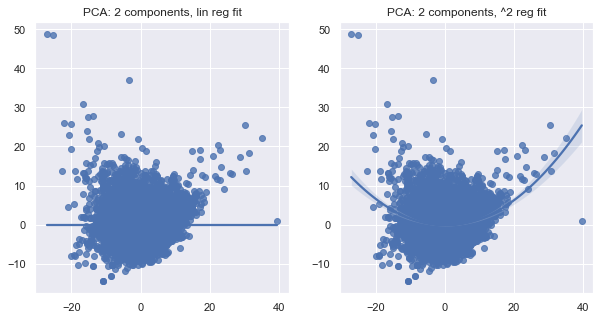

In [8]:
X_train_fts = X_train[fts.first()]

pca = PCA(n_components=2)
pca.fit(X_train_fts)

components = pca.transform(X_train_fts)
components_t = components.T

if viz:
    fig, axs = plt.subplots(ncols=2, figsize=(10,5))

    ax1 = sns.regplot(x=components_t[0], y=components_t[1], order=1, ax=axs[0]);
    ax1.set(title="PCA: 2 components, lin reg fit")
    
    ax2 = sns.regplot(x=components_t[0], y=components_t[1], order=2, ax=axs[1]);
    ax2.set(title="PCA: 2 components, ^2 reg fit")
    
    fig;


model = LinearRegression().fit(X_train_fts, y_train)

score = model.score(X_train_fts, y_train)
print(f'Linear regression: r2: {score}')

#### N components

Linear regression: r2: 0.1374642090606082


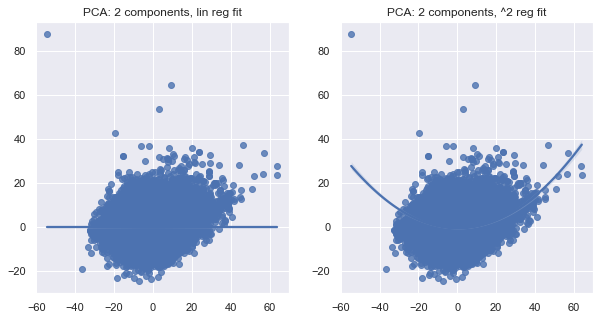

In [10]:
X_train_fts = X_train[fts.all()]

pca = PCA(n_components=10)
pca.fit(X_train_fts)

components = pca.transform(X_train_fts)
components_t = components.T

if viz:
    fig, axs = plt.subplots(ncols=2, figsize=(10,5))

    ax1 = sns.regplot(x=components_t[0], y=components_t[1], order=1, ax=axs[0]);
    ax1.set(title="PCA: 2 components, lin reg fit")
    
    ax2 = sns.regplot(x=components_t[0], y=components_t[1], order=2, ax=axs[1]);
    ax2.set(title="PCA: 2 components, ^2 reg fit")
    
    fig;


model = LinearRegression().fit(X_train_fts, y_train)

score = model.score(X_train_fts, y_train)
print(f'Linear regression: r2: {score}')

Linear regression: r2: 0.1374642090606082


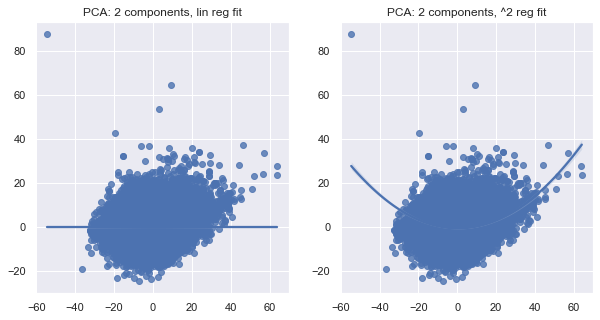

In [11]:
X_train_fts = X_train[fts.all()]

pca = PCA(n_components=100)
pca.fit(X_train_fts)

components = pca.transform(X_train_fts)
components_t = components.T

if viz:
    fig, axs = plt.subplots(ncols=2, figsize=(10,5))

    ax1 = sns.regplot(x=components_t[0], y=components_t[1], order=1, ax=axs[0]);
    ax1.set(title="PCA: 2 components, lin reg fit")
    
    ax2 = sns.regplot(x=components_t[0], y=components_t[1], order=2, ax=axs[1]);
    ax2.set(title="PCA: 2 components, ^2 reg fit")
    
    fig;


model = LinearRegression().fit(X_train_fts, y_train)

score = model.score(X_train_fts, y_train)
print(f'Linear regression: r2: {score}')

Linear regression: r2: 0.1374642090606082


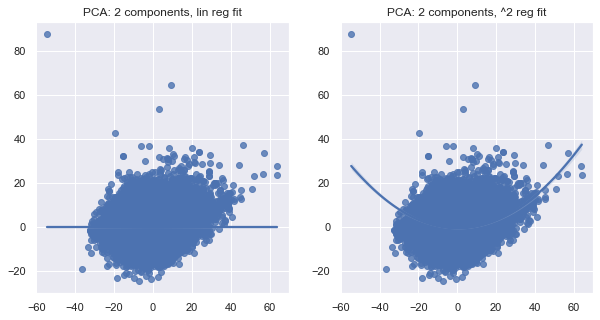

In [12]:
X_train_fts = X_train[fts.all()]

pca = PCA(n_components=250)
pca.fit(X_train_fts)

components = pca.transform(X_train_fts)
components_t = components.T

if viz:
    fig, axs = plt.subplots(ncols=2, figsize=(10,5))

    ax1 = sns.regplot(x=components_t[0], y=components_t[1], order=1, ax=axs[0]);
    ax1.set(title="PCA: 2 components, lin reg fit")
    
    ax2 = sns.regplot(x=components_t[0], y=components_t[1], order=2, ax=axs[1]);
    ax2.set(title="PCA: 2 components, ^2 reg fit")
    
    fig;


model = LinearRegression().fit(X_train_fts, y_train)

score = model.score(X_train_fts, y_train)
print(f'Linear regression: r2: {score}')

### 2. Models

#### Linear models

In [29]:
X_train_fts = X_train[fts.all()]
X_test_fts = X_test[fts.all()]

model = LinearRegression().fit(X_train_fts, y_train)
y_pred = model.predict(X_test_fts)

print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):3f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):3f}')
print(f'R2:  {metrics.r2_score(y_test, y_pred):3f}')

MAE: 0.918036
MSE: 1.354888
R2:  0.094467


In [6]:
X_train_fts = X_train[fts.all()]
X_test_fts = X_test[fts.all()]

# poly = PolynomialFeatures(2)
# X_train_fts = poly.fit_transform(X_train_fts)
# X_test_fts = poly.fit_transform(X_test_fts)

model = LinearRegression().fit(X_train_fts, y_train)
y_pred = model.predict(X_test_fts)

print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):3f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):3f}')
print(f'R2:  {metrics.r2_score(y_test, y_pred):3f}')

: 

: 

In [27]:
X_train_fts = X_train[fts.all()]
X_test_fts = X_test[fts.all()]

model = LinearRegression().fit(X_train_fts, y_train)
y_pred = model.predict(X_test_fts)

print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):3f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):3f}')
print(f'R2:  {metrics.r2_score(y_test, y_pred):3f}')

MAE: 0.918036
MSE: 1.354888
R2:  0.094467


In [26]:
X_train_fts = X_train[fts.all()]
X_test_fts = X_test[fts.all()]

model = ElasticNet().fit(X_train_fts, y_train)
y_pred = model.predict(X_test_fts)

print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):3f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):3f}')
print(f'R2:  {metrics.r2_score(y_test, y_pred):3f}')

MAE: 0.986608
MSE: 1.541923
R2:  -0.030537


#### Support vector regression

In [6]:
X_train_fts = X_train[fts.all()]
X_test_fts = X_test[fts.all()]

model = SVR().fit(X_train_fts, y_train)
y_pred = model.predict(X_test_fts)

print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):3f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):3f}')
print(f'R2:  {metrics.r2_score(y_test, y_pred):3f}')

#### K neighbors

In [5]:
X_train_fts = X_train[fts.all()]
X_test_fts = X_test[fts.all()]

model = KNeighborsRegressor().fit(X_train_fts, y_train)
y_pred = model.predict(X_test_fts)

print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):3f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):3f}')
print(f'R2:  {metrics.r2_score(y_test, y_pred):3f}')

MAE: 0.939816
MSE: 1.448443
R2:  0.031941


### 3. Hyperparameters